In [1]:
import GPy
import numpy as np
from matplotlib import pyplot as plt
from gp_binary import *
%matplotlib inline

# Bayesian optimization with binary outputs

### Written by Javier Gonzalez, Amazon Cambridge

*Last updated, January. 2019.*

### Goal of this notebook

The goal of this notebook is to show how Emukit can be used to perform Bayesian optimization when the variable to optimize is binary.  In other words, we want to select the point $x$ that maximizes the probability of success of certain event in a given domain. We start by assuming that there exist a latent function $f$ that once warped represents the probability of success $p(y=+1|x) = \sigma(f(x))$. The observables at each $x$ are Bernoulli trials with this probability.

### Problem definition

The probability of success is defined as a warping to the [0,1] interval of the negative Forrester function (available in the tests set of Emukit).

In [2]:
from emukit.test_functions.forrester import forrester
from emukit.core import ParameterSpace, ContinuousParameter

# latent objective function
latent_function = forrester

def prob_success(x):
    likelihood  = GPy.likelihoods.Bernoulli()
    return likelihood.gp_link.transf(latent_function(x))

def binary_objective(x):
    likelihood  = GPy.likelihoods.Bernoulli()
    return likelihood.samples(latent_function(x)).reshape(-1,1)
    
def binary_objective_evaluate(x):
    ## NOTE: we do 1-latent_function as we minimize
    likelihood  = GPy.likelihoods.Bernoulli()
    return likelihood.samples(1-latent_function(x)).reshape(-1,1) 
    
## Boundaries and parameter space of the problem
lb = 0
ub = 1
parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1)])

Text(0.5,1,'Latent function')

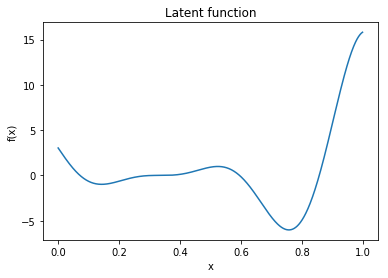

In [3]:
X_line = np.arange(lb, ub, 0.001)
plt.plot(X_line,latent_function(X_line), label = '$f(x)$')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Latent function')

Instead of observing $\sigma(f(x))$ we observe Bernuilli random trials. For instance, once we have queried the locations X we observe the resulting binary outcomes

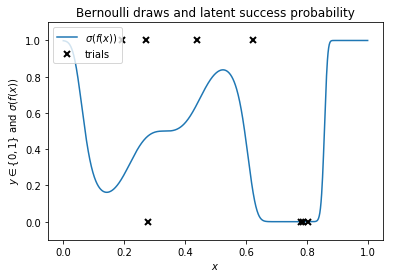

In [4]:
## -- Plot of lantent probability and samples

num_locations = 8
np.random.seed(1234)
X = np.random.rand(num_locations,1)
Y = binary_objective(X)

plt.plot(X_line, prob_success(X_line), label = '$\sigma(f(x))$')
plt.ylim([0,1.05])
plt.xlabel('x')
plt.title('Objective latent function')
plt.plot(X, Y, 'kx', mew=2, label = 'trials');plt.ylim(-0.1, 1.1)
plt.title('Bernoulli draws and latent success probability');plt.xlabel('$x$');plt.ylabel('$y \in \{0,1\}$ and $\sigma(f(x))$')
plt.legend(loc = 2 )

### Defining the elements of the problem for BayesOpt

The key elements of any Bayesian optimization methods are the model and the acquisition function. To create the model we use GPy and define a GP model with binary outputs (Bernoulli likelihood). The default kernel is a Mattern52. Inference is done with EP but this can be changed.

In [5]:
# -- We initialize the model with binary outputs in the file g_binary
inference_type = EP() #Laplace()
likelihood = Bernoulli()
kernel = GPy.kern.Matern52(1, variance=1.)

Next we initialize the rest of the elements needed for the optimization, including some initial locations. We need to run this with very low data. The example just tries to illustrate how to do things, not to solve this problem yet.

In [6]:
from emukit.model_wrappers import GPyModelBinaryOutputsWrapper

model_gpy = GPy.core.GP(X=X, Y=Y, kernel=kernel, inference_method=inference_type, likelihood=likelihood)
#Z = np.random.rand(100,1)
#model_gpy = GPy.core.SVGP(X,Y,Z, kernel=kernel,likelihood=likelihood)
#model_gpy.Z.fix(warning=False)
model_emukit = GPyModelBinaryOutputsWrapper(model_gpy)
model_emukit.optimize()

In [7]:
model_emukit.model

gp.,value,constraints,priors
Mat52.variance,0.4285095465865185,+ve,
Mat52.lengthscale,0.05619928010883113,+ve,


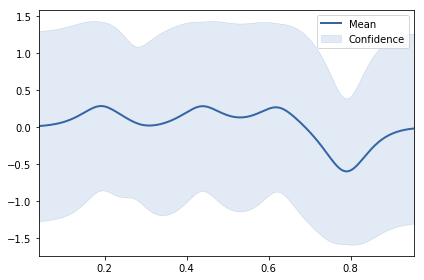

In [8]:
model_gpy.plot_f()

In [9]:
model_gpy.X

ObsAr([[0.19151945],
       [0.62210877],
       [0.43772774],
       [0.78535858],
       [0.77997581],
       [0.27259261],
       [0.27646426],
       [0.80187218]])

Now we can do Bayesian optimization with this model using any of the usual aquisition functions. Note that now, when predictions are made with the model we always use the distribution of the latent function rather than binary outputs. Intuitively, this is done because new observations should help to shrink the 'reducible' uncertainty. For example if we are very certain of the value of $f$ at $\textbf{x}$ but $\sigma(f(\textbf{x}))=0.5$ the variance of the output is at its maximum $0.5\times(1-.5)$ and is not reducible by knowing more about $f$.

In [10]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement

expected_improvement = ExpectedImprovement(model = model_emukit)

In [11]:
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

bayesopt_loop = BayesianOptimizationLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = expected_improvement,
                                         batch_size = 1)

In [12]:
max_iterations = 1
bayesopt_loop.run_loop(binary_objective_evaluate, max_iterations)

ValueError: operands could not be broadcast together with shapes (8,1) (9,9) 

In [194]:
bayesopt_loop.loop_state.X

array([[0.69646919],
       [0.28613933],
       [0.22685145],
       [0.55131477],
       [0.71946897],
       [0.42310646],
       [0.9807642 ],
       [0.68482974],
       [0.4809319 ],
       [0.39211752],
       [0.34317802],
       [0.72904971],
       [0.43857224],
       [0.0596779 ],
       [0.39804426],
       [0.73799541],
       [0.18249173],
       [0.17545176],
       [0.53155137],
       [0.53182759],
       [0.72277381],
       [0.72948358],
       [0.74940388],
       [0.87473189],
       [0.99989006],
       [0.99731206],
       [0.99559739],
       [0.99885136],
       [0.99937513],
       [0.99920247],
       [0.99919917],
       [0.99936363],
       [0.99854659],
       [0.99951462],
       [0.9965431 ],
       [0.99964534],
       [0.99892233],
       [0.99945282],
       [0.99963133],
       [0.9993972 ],
       [0.99951171],
       [0.99694138],
       [0.99978718],
       [0.99987578],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.   

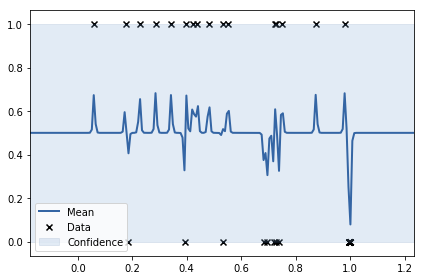

In [195]:
bayesopt_loop.model.model.plot()

We plot the observations and the p(y|x)

We plot the observations and p(f|x). Note that, so far, the acquisition function is based on $f$ not on $y$. The reason for this is that following BO priciples, uncertainty about $f$ (exploration) can be rediced with further observations but uncertainty about y doesn't.

And we show the visited locations and the outputs, remember that 0 is good as we are minimizing :)